# Milestone 3: Deep Dive

### 3.1 : Load Essential Libraries

In [1]:
import re
import pandas as pd
import sqlite3
import seaborn as sns
%reload_ext sql
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

conn = sqlite3.connect("congressional_tweets.db")
%sql sqlite:///congressional_tweets.db


### 3.2 : TF-IDF for Word Frequency / Theme Analysis

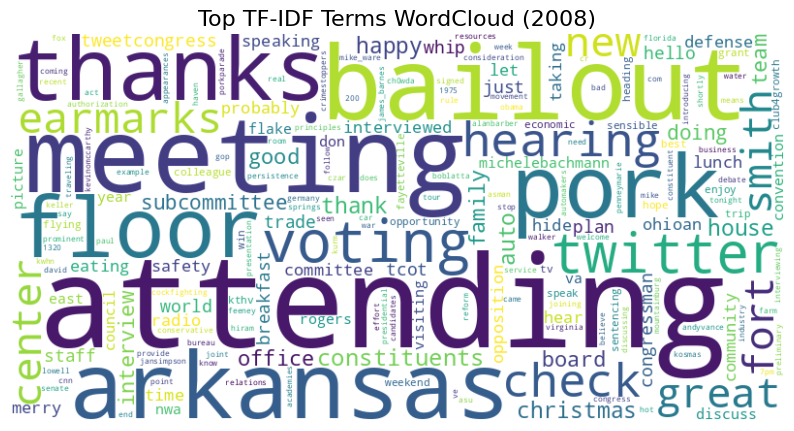

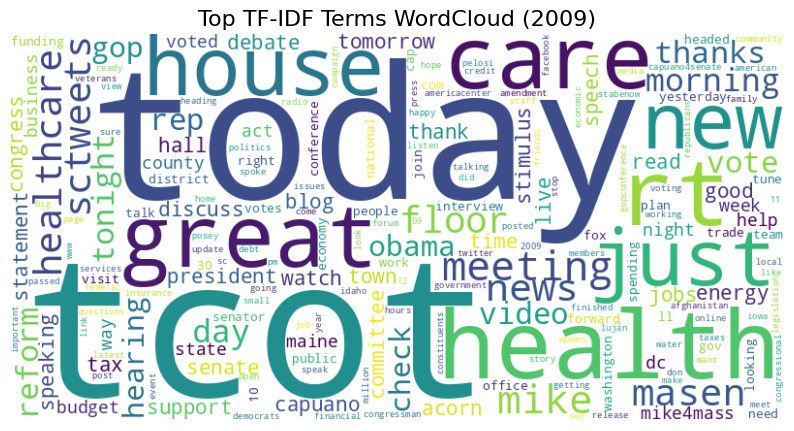

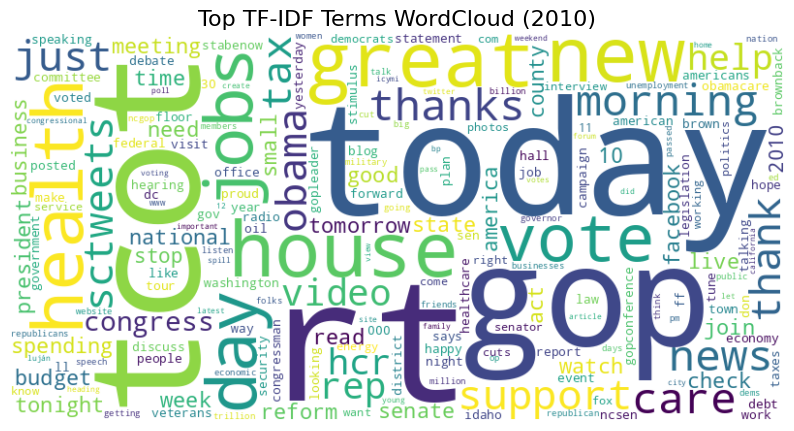

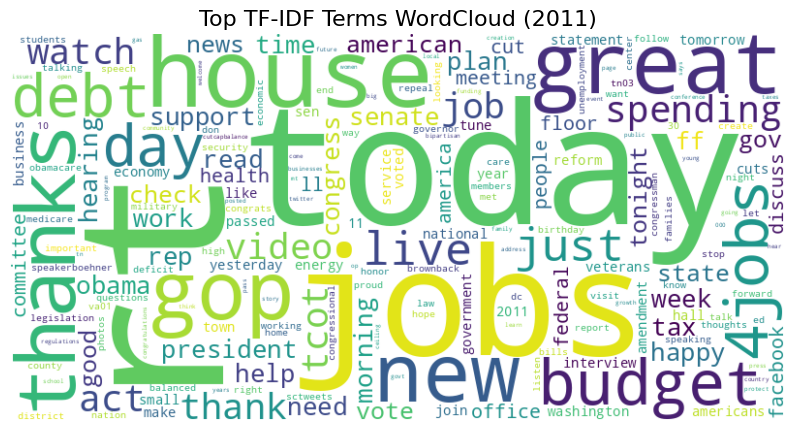

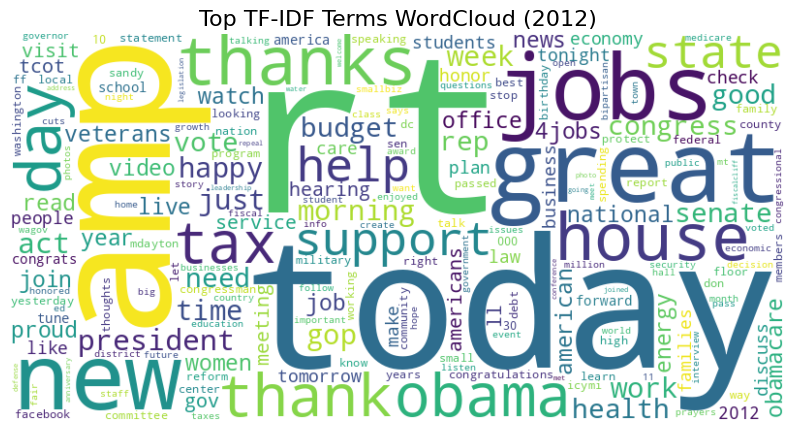

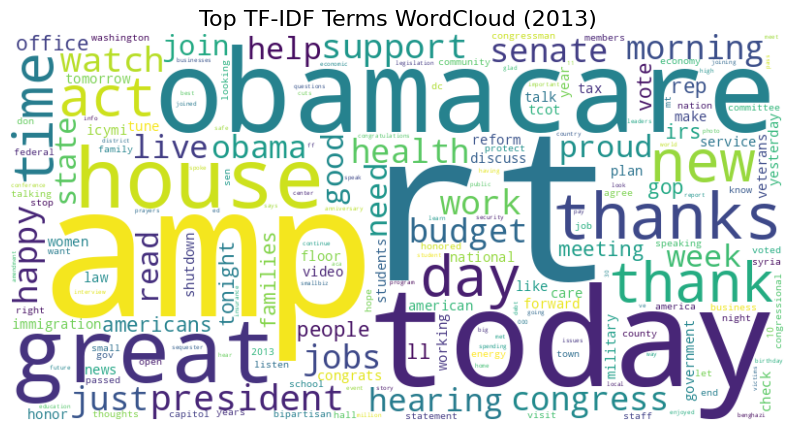

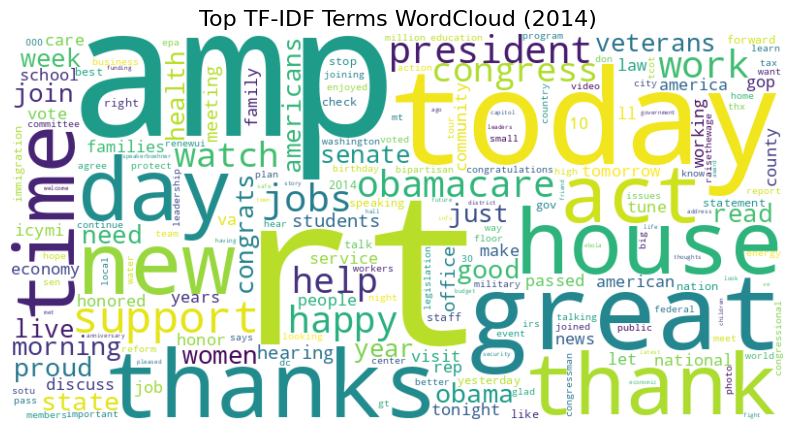

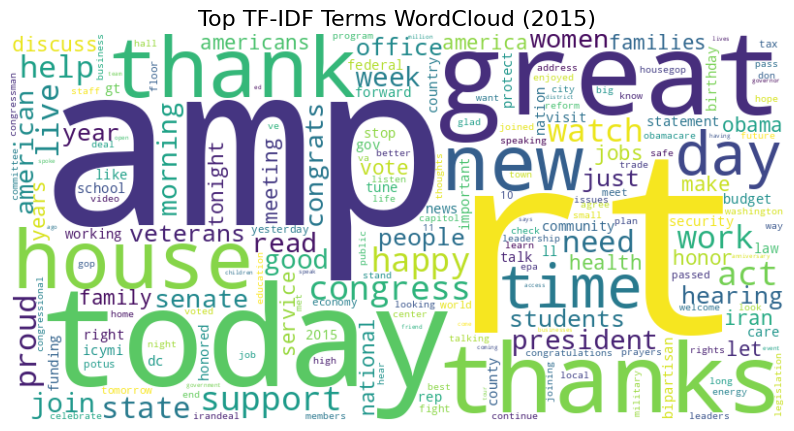

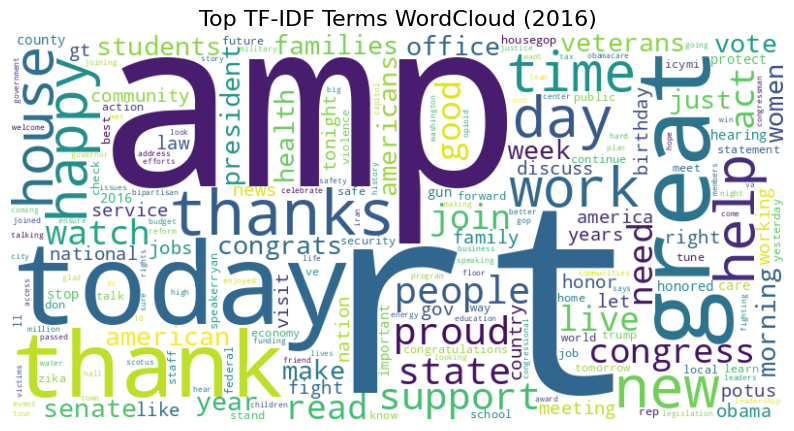

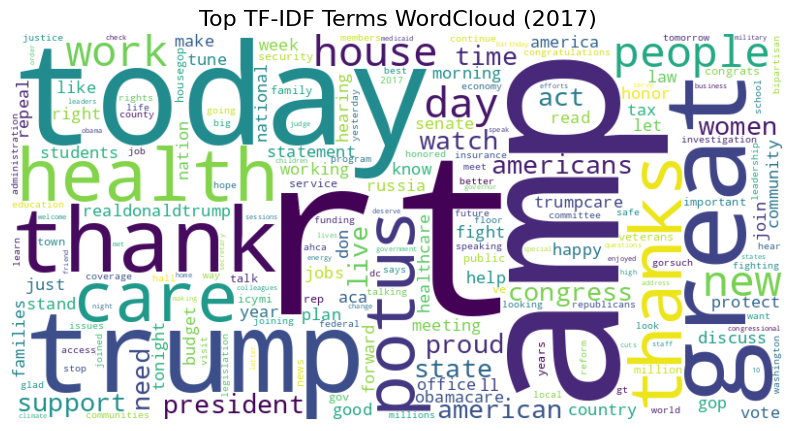

In [2]:

query_texts = """
SELECT 
    id,        
    text,
    created_at        
FROM tweets
WHERE text IS NOT NULL
  AND TRIM(text) != '';
"""

df_texts = pd.read_sql_query(query_texts, conn)
def clean_text(text):
    text = re.sub(r"http\S+|https\S+", "", text)  # Remove http and https links
    return text

df_texts['clean_text'] = df_texts['text'].apply(clean_text)

# Convert to datetime
df_texts["created_at"] = pd.to_datetime(df_texts["created_at"])
df_texts["year"] = df_texts["created_at"].dt.year

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

for year, group in df_texts.groupby("year"):
    X_tfidf = vectorizer.fit_transform(group['clean_text'])
    tfidf_df = pd.DataFrame(
        X_tfidf.toarray(), 
        columns=vectorizer.get_feature_names_out(), 
        index=group["id"]
    )

    # Sum TF-IDF scores
    term_scores = tfidf_df.sum(axis=0).sort_values(ascending=False)

    # Generate WordCloud weighted by TF-IDF scores
    wc = WordCloud(width=800, height=400, 
                   background_color="white",
                   colormap="viridis").generate_from_frequencies(term_scores.to_dict())

    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Top TF-IDF Terms WordCloud ({year})", fontsize=16)
    plt.savefig(f'./plots/tweets_per_{year}.png', dpi=300, bbox_inches='tight')  
    plt.show()

### 3.2 : Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ashmin/nltk_data...


                                                text  sentiment
0  On a conference call about a weekend trip to I...     0.0000
1                          Being interviewed by KTHV     0.0000
2  Being interviewed by KARN on his Arkansas Worl...     0.0000
3              On KWHN in Fort Smith, that's 1320 AM     0.0000
4  Attending a Military of the Purple Heart Cerem...     0.0000
5      Touring Helath South Hospital in Fayetteville     0.0000
6  conducting a veterans affairs economic opportu...     0.4215
7                   doing an interview on kurm radio     0.0000
8  Meeting with Emergency Management officials fr...    -0.3818
9  Listening to constituents at a roundtable disc...     0.0000


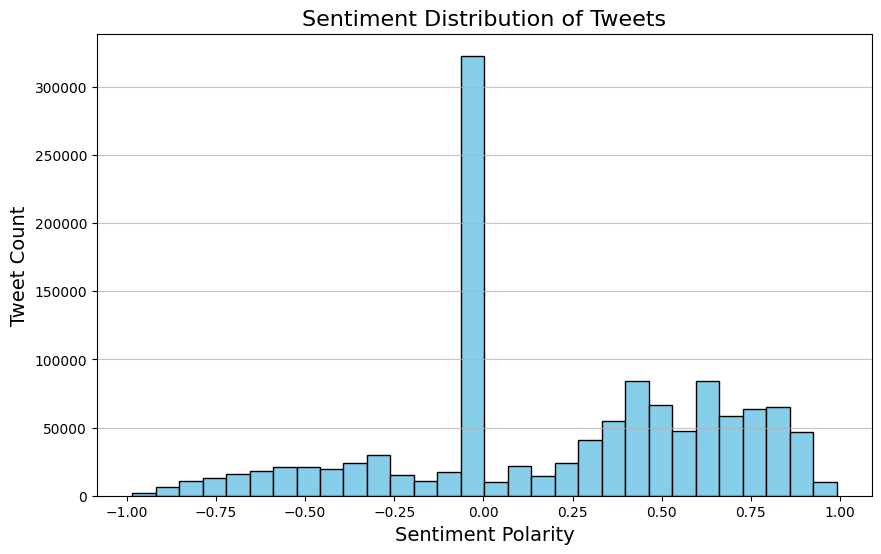

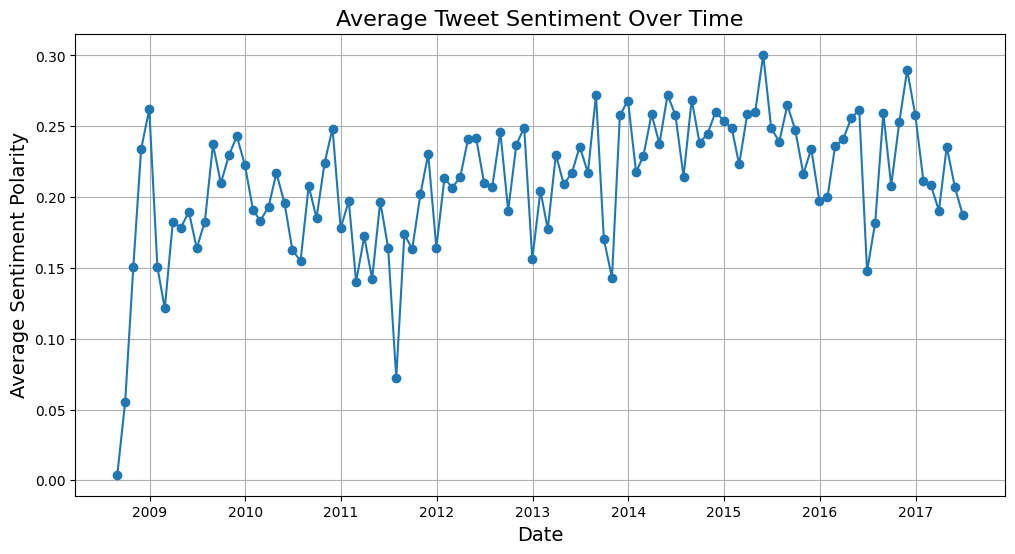

In [3]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Sentiment analysis
df_texts["sentiment"] = df_texts["text"].apply(lambda x: sia.polarity_scores(x)["compound"])
print(df_texts[["text", "sentiment"]].head(10))

# Sentiment distribution
plt.figure(figsize=(10,6))
plt.hist(df_texts["sentiment"], bins=30, color="skyblue", edgecolor="black")
plt.title("Sentiment Distribution of Tweets", fontsize=16)
plt.xlabel("Sentiment Polarity", fontsize=14)
plt.ylabel("Tweet Count", fontsize=14)
plt.grid(axis="y", alpha=0.75)
plt.show()  

# Average sentiment over time
df_texts.set_index("created_at", inplace=True)
sentiment_over_time = df_texts["sentiment"].resample("ME").mean()

plt.figure(figsize=(12,6))
plt.plot(sentiment_over_time.index, sentiment_over_time.values, marker='o', linestyle='-')
plt.title("Average Tweet Sentiment Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Average Sentiment Polarity", fontsize=14)
plt.grid(True)
plt.show()


### 3.3 : New Metric

Metric 1 (for Hypothesis 2): Topic Share per Year (Healthcare, Finance, Defense, etc.).

Metric 2 (for Hypothesis 3): Intra-User Mention Ratio (%).

#### 3.3.1 : Metric 1

   year  Healthcare    Finance   Defense
0  2008    0.000000   0.892857  5.357143
1  2009   11.756133   7.104688  2.963323
2  2010    7.919785   9.634527  2.492189
3  2011    4.354008  13.079089  2.977562
4  2012    5.908527   9.645410  2.573291


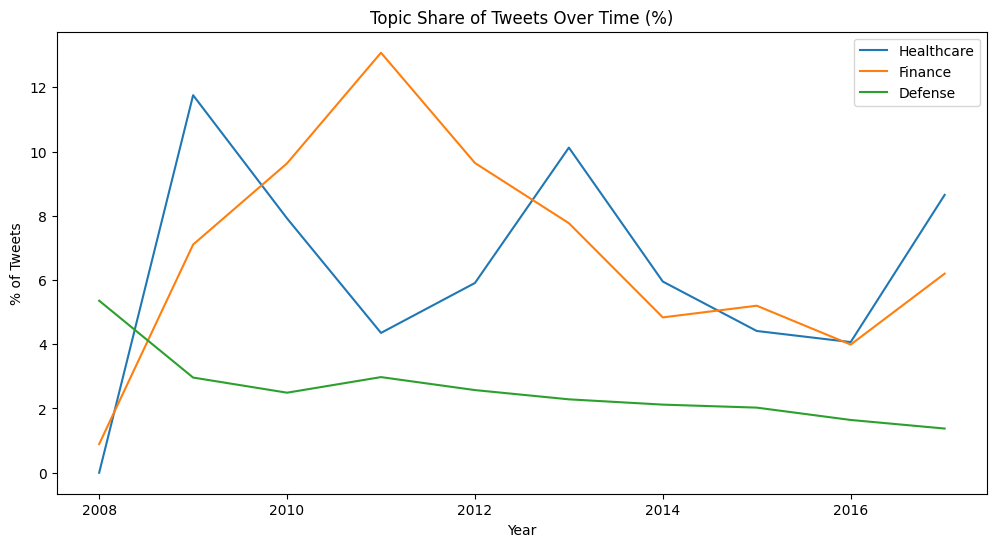

In [4]:
# Load from SQL
query = """
SELECT 
    id AS tweet_id,
    text,
    created_at
FROM tweets
WHERE text IS NOT NULL
  AND TRIM(text) != '';
"""

df_texts = pd.read_sql_query(query, conn)

# Convert to datetime
df_texts["created_at"] = pd.to_datetime(df_texts["created_at"])
df_texts["year"] = df_texts["created_at"].dt.year


# Define topic keywords
topics = {
    "Healthcare": ["health", "healthcare", "medicare", "medicaid", "obamacare"],
    "Finance": ["tax", "budget", "finance", "debt", "economy"],
    "Defense": ["defense", "military", "iraq", "afghanistan", "troops"]
}

# Function to check if tweet text contains any topic keyword
def classify_topic(text, keywords):
    text_lower = text.lower()
    return any(kw in text_lower for kw in keywords)

# Count topic frequency per year
results = []
for topic, keywords in topics.items():
    topic_mask = df_texts["text"].str.lower().apply(lambda t: classify_topic(t, keywords))
    topic_counts = df_texts[topic_mask].groupby("year").size()
    total_counts = df_texts.groupby("year").size()
    share = (topic_counts / total_counts * 100).fillna(0)
    share.name = topic
    results.append(share)

topic_trends = pd.concat(results, axis=1).fillna(0).reset_index()
print(topic_trends.head())


# Plot topic trends
plt.figure(figsize=(12,6))
for col in topics.keys():
    plt.plot(topic_trends["year"], topic_trends[col], label=col)

plt.title("Topic Share of Tweets Over Time (%)")
plt.xlabel("Year")
plt.ylabel("% of Tweets")
plt.legend()
plt.show()



#### 3.3.2 : Metric 2: Intra-User Mention Ratio (%)

Neither tweets nor users tables has a party field. So We'll calculate the Intra-Community Mention Ratio year by year.

   year  top_user_mentions  total_mentions  intra_community_ratio
0  2008                0.0              18               0.000000
1  2009                0.0            1455               0.000000
2  2010               10.0            4253               0.235128
3  2011              158.0           19736               0.800567
4  2012              752.0           34478               2.181101
5  2013             3427.0           90933               3.768709
6  2014             7626.0          137428               5.549088
7  2015            14089.0          225983               6.234540
8  2016            19982.0          308070               6.486188
9  2017            11175.0          196234               5.694732


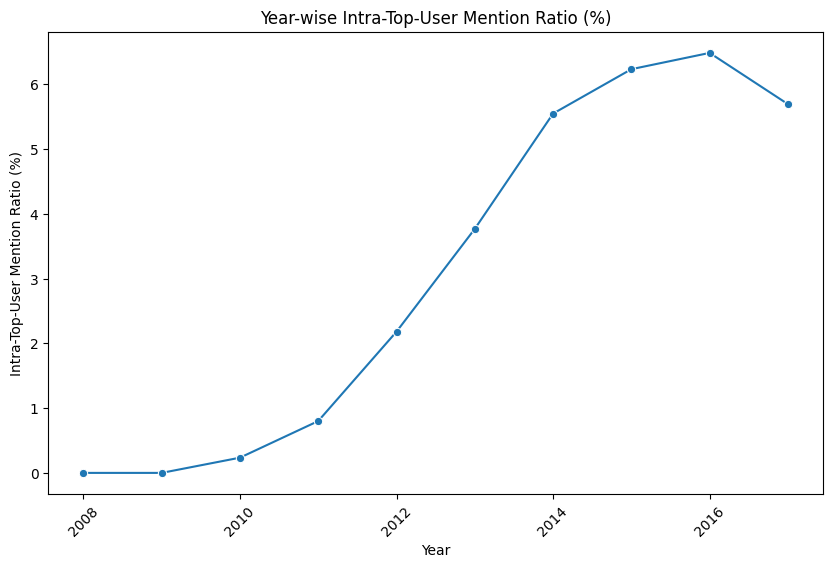

In [5]:
import seaborn as sns
import ast

# Load from SQL
query = """
SELECT 
    id AS tweet_id,
    text,
    created_at,
    screen_name,
    mentions
FROM tweets
WHERE text IS NOT NULL
  AND TRIM(text) != '';
"""

df_texts = pd.read_sql_query(query, conn)

# Convert to datetime
df_texts["created_at"] = pd.to_datetime(df_texts["created_at"])
df_texts["year"] = df_texts["created_at"].dt.year

# Step 0: Ensure 'mentions' is a list
df_texts['mentions'] = df_texts['mentions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 1: Explode mentions and keep year
df_mentions_year = df_texts[['screen_name', 'mentions', 'year']].explode('mentions').dropna()

# Step 2: Identify top N active users
top_users = df_mentions_year['screen_name'].value_counts().head(100).index.tolist()

# Step 3: Keep only mentions among top users
df_top_mentions = df_mentions_year[
    df_mentions_year['screen_name'].isin(top_users) & 
    df_mentions_year['mentions'].isin(top_users)
]

# Step 4: Calculate intra-top-user mention ratio per year
yearly_ratios = (
    df_top_mentions.groupby('year')
    .size()  # Total mentions among top users per year
    .reset_index(name='top_user_mentions')
)

# Step 5: Total mentions per year (all mentions)
total_mentions_year = (
    df_mentions_year.groupby('year')
    .size()
    .reset_index(name='total_mentions')
)

# Step 6: Merge and calculate percentage
df_yearly = pd.merge(yearly_ratios, total_mentions_year, on='year', how='right')
df_yearly['intra_community_ratio'] = df_yearly['top_user_mentions'] / df_yearly['total_mentions'] * 100
df_yearly.fillna(0, inplace=True)

print(df_yearly)

# Step 7: Plot
plt.figure(figsize=(10,6))
sns.lineplot(data=df_yearly, x='year', y='intra_community_ratio', marker='o')
plt.title("Year-wise Intra-Top-User Mention Ratio (%)")
plt.ylabel("Intra-Top-User Mention Ratio (%)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()

Top 3 most active users and track:

1) Who they mention the most.

2) Who mentions them back.

Top 5 Users by Followers:
          screen_name  followers_count
150  realDonaldTrump         31712585
147            POTUS         18545354
509       SenSanders          5072538
31        CoryBooker          3094413
118       marcorubio          2554822


/tmp/ipykernel_7742/4166286456.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_outgoing_top5 = top5_outgoing.groupby('screen_name').apply(top_mentions).reset_index(drop=True)
/tmp/ipykernel_7742/4166286456.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_incoming_top5 = top5_incoming.groupby('mentions').apply(top_incoming).reset_index(drop=True)



Top 5 Outgoing Mentions per Top 5 Users:
         screen_name   mentioned_user  mention_count
0        CoryBooker       CoryBooker            436
1        CoryBooker  SenBookerOffice            211
2        CoryBooker           ghelmy             90
3        CoryBooker   HillaryClinton             41
4        CoryBooker  SenatorMenendez             35
5             POTUS  realDonaldTrump            119
6             POTUS            POTUS            107
7             POTUS       WhiteHouse             99
8             POTUS               VP             54
9             POTUS           FLOTUS             27
10       SenSanders       SenSanders            102
11       SenSanders  realDonaldTrump             26
12       SenSanders        SenWarren             15
13       SenSanders            POTUS             13
14       SenSanders   SenJeffMerkley             13
15       marcorubio       marcorubio            588
16       marcorubio        TeamMarco            208
17       marcorubio  

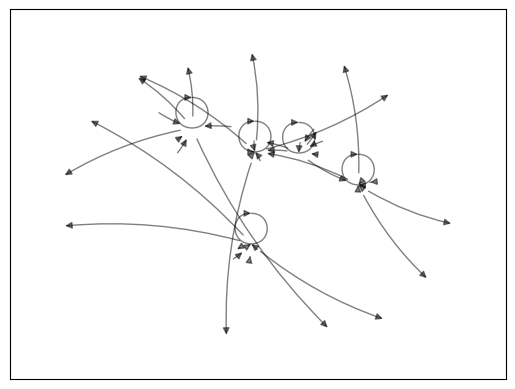

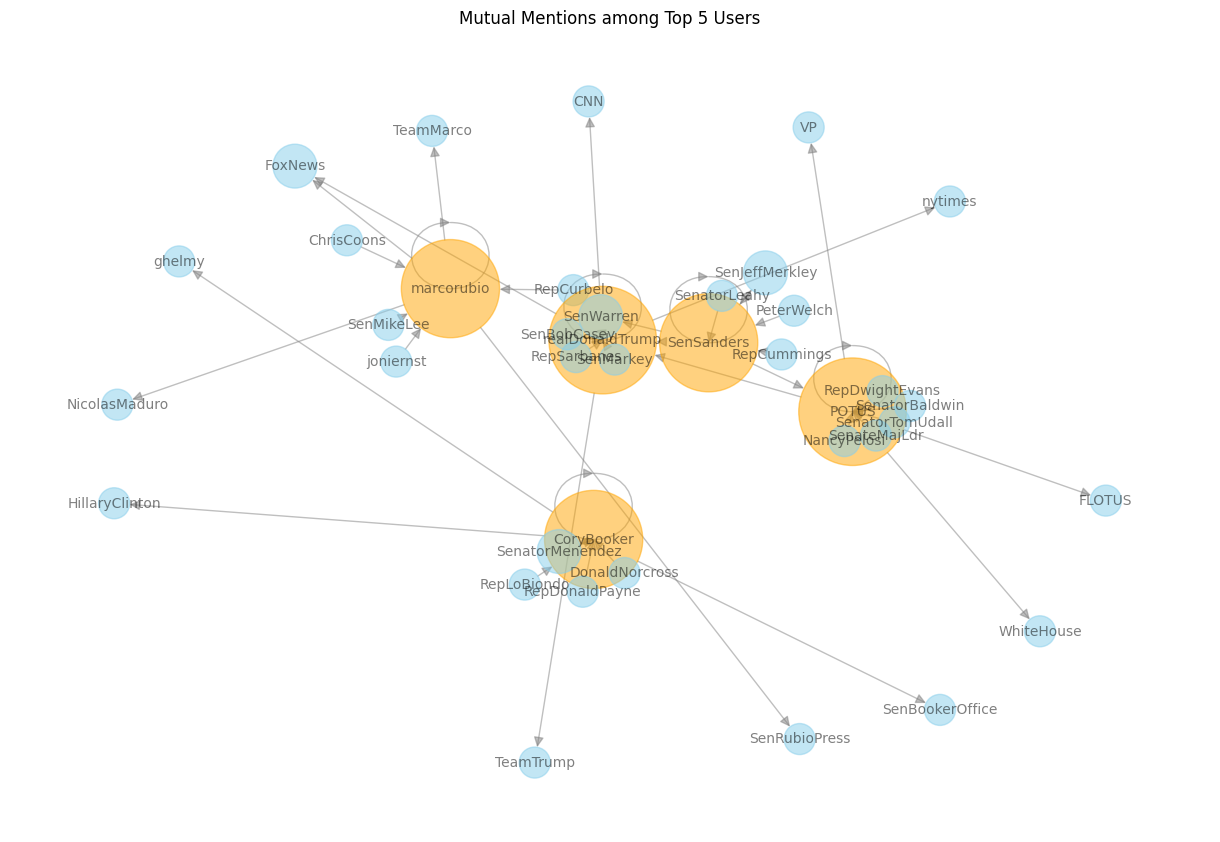

In [6]:
import ast
import networkx as nx


# Connect to database
conn = sqlite3.connect("congressional_tweets.db")

# Load tweets and users
tweets_query = """
SELECT 
    screen_name,
    mentions
FROM tweets
WHERE mentions IS NOT NULL
"""
tweets_df = pd.read_sql_query(tweets_query, conn)

users_query = """
SELECT 
    screen_name,
    followers_count
FROM users
"""
users_df = pd.read_sql_query(users_query, conn)

# Convert mentions from string to list if needed
def ensure_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    elif isinstance(x, list):
        return x
    return []

tweets_df['mentions'] = tweets_df['mentions'].apply(ensure_list)

# Top 5 users by followers
top5_users = users_df.nlargest(5, 'followers_count')
top5_screen_names = top5_users['screen_name'].tolist()
print("Top 5 Users by Followers:\n", top5_users)

# Explode mentions
mentions_exploded = tweets_df[['screen_name', 'mentions']].explode('mentions').dropna()

# Outgoing mentions per top 5 user (top 5 mentions)
top5_outgoing = mentions_exploded[mentions_exploded['screen_name'].isin(top5_screen_names)]

def top_mentions(df):
    temp = df['mentions'].value_counts().nlargest(5).reset_index()
    temp.columns = ['mentioned_user', 'mention_count']
    temp['screen_name'] = df.name  # 'df.name' is the group key
    return temp[['screen_name', 'mentioned_user', 'mention_count']]

top5_outgoing_top5 = top5_outgoing.groupby('screen_name').apply(top_mentions).reset_index(drop=True)
print("\nTop 5 Outgoing Mentions per Top 5 Users:\n", top5_outgoing_top5)

# Incoming mentions for top 5 users (who mentions them back)
top5_incoming = mentions_exploded[mentions_exploded['mentions'].isin(top5_screen_names)]

def top_incoming(df):
    temp = df['screen_name'].value_counts().nlargest(5).reset_index()
    temp.columns = ['screen_name', 'mention_count']
    temp['mentioned_user'] = df.name
    return temp[['mentioned_user', 'screen_name', 'mention_count']]

top5_incoming_top5 = top5_incoming.groupby('mentions').apply(top_incoming).reset_index(drop=True)
print("\nTop 5 Incoming Mentions for Top 5 Users:\n", top5_incoming_top5)

# Mutual mentions: users appearing in both outgoing and incoming top mentions
mutual_top_users = list(set(top5_outgoing_top5['screen_name']) & set(top5_incoming_top5['mentioned_user']))
print("\nUsers present in both outgoing and incoming top mentions:", mutual_top_users)

# Show outgoing and incoming top mentions only for mutual users
mutual_mentions = {}
for user in mutual_top_users:
    outgoing_list = top5_outgoing_top5[top5_outgoing_top5['screen_name'] == user][['mentioned_user', 'mention_count']]
    incoming_list = top5_incoming_top5[top5_incoming_top5['mentioned_user'] == user][['screen_name', 'mention_count']]
    mutual_mentions[user] = {
        'outgoing_mentions': outgoing_list,
        'incoming_mentions': incoming_list
    }

# Example: print mutual mentions for first user
first_user = mutual_top_users[0]
print(f"\nMutual mentions for {first_user}:")
print("Outgoing:\n", mutual_mentions[first_user]['outgoing_mentions'])
print("Incoming:\n", mutual_mentions[first_user]['incoming_mentions'])



# Create directed graph
G = nx.DiGraph()

# Add edges from mutual mentions
for user, data in mutual_mentions.items():
    for _, row in data['outgoing_mentions'].iterrows():
        G.add_edge(user, row['mentioned_user'], weight=row['mention_count'])
    for _, row in data['incoming_mentions'].iterrows():
        G.add_edge(row['screen_name'], user, weight=row['mention_count'])



pos = nx.spring_layout(G, k=3, iterations=200)
node_sizes = [G.degree(n)*500 for n in G.nodes()]  # or followers_count
colors = ['orange' if n in top5_screen_names else 'skyblue' for n in G.nodes()]
edges_to_draw = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 2]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, connectionstyle='arc3, rad=0.1', alpha=0.5)
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos, with_labels=True, node_color=colors,
    node_size=node_sizes, edge_color='gray', alpha=0.5,
    font_size=10, arrowsize=15
)
plt.title("Mutual Mentions among Top 5 Users")
plt.show()

